In [2]:
from matplotlib.pyplot import imshow
import matplotlib.cm as cm
import matplotlib.pylab as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import PIL
from PIL import ImageFilter
import cv2
import itertools
import random
import keras
import imutils
from imutils import paths
import os
from keras import optimizers
from tensorflow.keras.utils import img_to_array
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import callbacks
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D , UpSampling2D ,Conv2DTranspose
from keras import backend as K

%matplotlib inline

2023-05-23 19:19:16.637268: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def pil_image(img_path):
    pil_im =PIL.Image.open(img_path).convert('L')
    pil_im=pil_im.resize((105,105))
    #imshow(np.asarray(pil_im))
    return pil_im

In [4]:
data_path = "font_patch/"
data=[]
labels=[]
imagePaths = sorted(list(paths.list_images(data_path)))
random.seed(42)
random.shuffle(imagePaths)

In [5]:
def conv_label(label):
    if label == 'Lato':
        return 0
    elif label == 'Raleway':
        return 1
    elif label == 'Roboto':
        return 2
    elif label == 'Sansation':
        return 3
    elif label == 'Walkway':
        return 4

In [6]:
counter=0
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    label = conv_label(label)
    pil_img = pil_image(imagePath)
    #imshow(pil_img)
    
    # Adding original image
    org_img = img_to_array(pil_img)
    #print(org_img.shape)
    data.append(org_img)
    labels.append(label)

In [7]:
data = np.asarray(data, dtype="float") / 255.0
labels = np.array(labels)
print("Success")
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.25, random_state=42)

Success


In [8]:
trainY = to_categorical(trainY, num_classes=5)
testY = to_categorical(testY, num_classes=5)

In [9]:
def create_model():
  model=Sequential()

  # Cu Layers 
  model.add(Conv2D(64, kernel_size=(48, 48), activation='relu', input_shape=(105,105,1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, kernel_size=(24, 24), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2DTranspose(128, (24,24), strides = (2,2), activation = 'relu', padding='same', kernel_initializer='uniform'))
  model.add(UpSampling2D(size=(2, 2)))

  model.add(Conv2DTranspose(64, (12,12), strides = (2,2), activation = 'relu', padding='same', kernel_initializer='uniform'))
  model.add(UpSampling2D(size=(2, 2)))

  #Cs Layers
  model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))

  model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))

  model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))

  model.add(Flatten())

  model.add(Dense(4096, activation='relu'))

  model.add(Dropout(0.5))

  model.add(Dense(4096,activation='relu'))

  model.add(Dropout(0.5))

  model.add(Dense(2383,activation='relu'))

  model.add(Dense(5, activation='softmax'))
 
  return model

In [10]:
batch_size = 128
epochs = 10
model= create_model()
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

/Users/apple/Desktop/font-recognition/.venv/lib/python3.11/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')

filepath="top_model.h5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [early_stopping,checkpoint]

In [12]:
history=model.fit(trainX, trainY,shuffle=True,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(testX, testY),callbacks=callbacks_list)

Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.1724
Epoch 1: val_loss improved from inf to 0.15909, saving model to top_model.h5
1/1 [==============================] - 115s 115s/step - loss: 0.1660 - accuracy: 0.1724 - val_loss: 0.1591 - val_accuracy: 0.6000
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.2759
Epoch 2: val_loss improved from 0.15909 to 0.15811, saving model to top_model.h5
1/1 [==============================] - 134s 134s/step - loss: 0.1549 - accuracy: 0.2759 - val_loss: 0.1581 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 0.1645 - accuracy: 0.3103
Epoch 3: val_loss improved from 0.15811 to 0.15726, saving model to top_model.h5
1/1 [==============================] - 86s 86s/step - loss: 0.1645 - accuracy: 0.3103 - val_loss: 0.1573 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 0.1445 - accuracy: 0.4138
Epoch

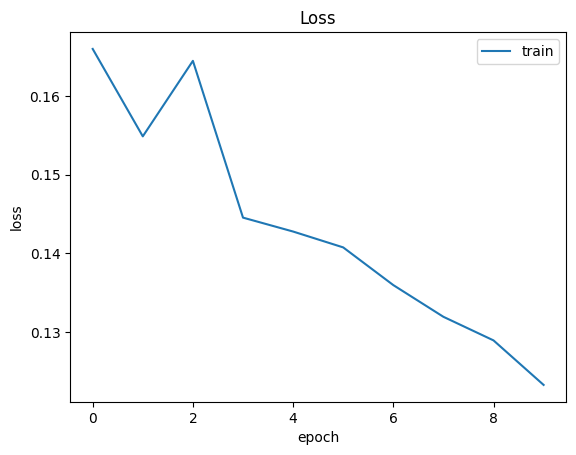

In [14]:
plt.plot(history.history['loss'], label='loss')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train'],loc='upper right')
plt.show()

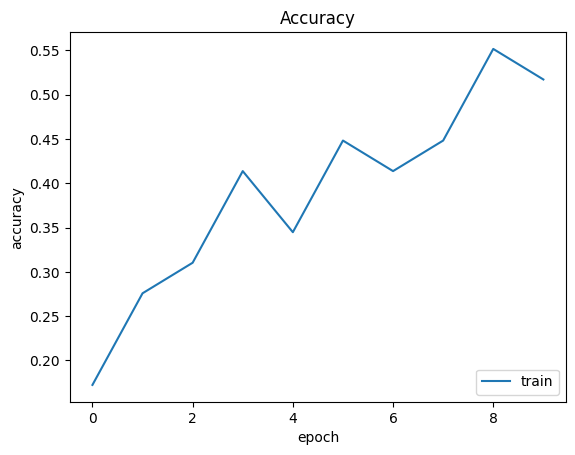

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train'],loc='lower right')
plt.show()

In [13]:
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.15346089005470276
Test accuracy: 0.5
